In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
sys.path.append(os.path.abspath('../scripts'))
from plots import *
from data_processing import *
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
import ruptures as rpt
import pymc as pm

In [5]:
path = '../data/Copy of BrentOilPrices.csv'
df = load_data(path)

2024-11-15 22:32:27,153 - INFO - Loading data from file...
2024-11-15 22:32:27,582 - INFO - Data loaded 


In [17]:
df.head()

,Price
Date,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-25,18.60
1987-05-26,18.63


In [14]:
df.shape

(9011, 1)

In [11]:
df.isnull().sum()

Price    0
dtype: int64

## Visualize Data

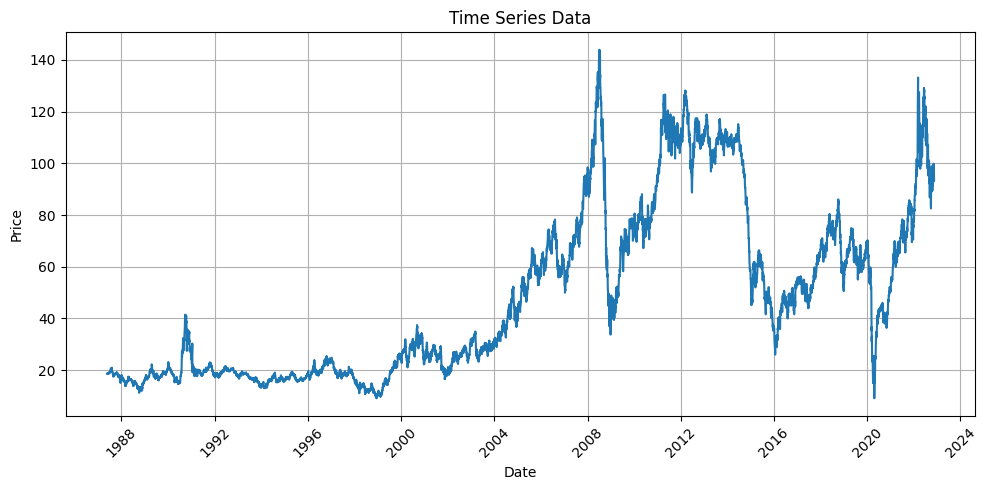

In [ ]:
time_series(df,'Price', 'Brent Oil Price')

## Seasonality

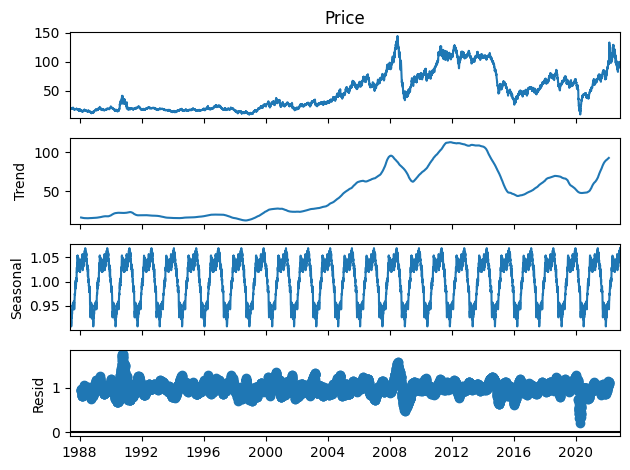

In [9]:
seasonality(df,'Price', 'multiplicative')

- Trend : shows the data moving in a generally upward direction, with some periods of decline, but the overall trend is positive.
- Seasonal graph: The repeating waves suggest the presence of seasonal factors that influence the data over time.
- Residual graph: displays the residuals, which are the differences between the actual data points and the predicted or expected values based on the overall trend and seasonal patterns. The residuals appear to fluctuate around a zero baseline, indicating that the model used to generate the trend and seasonal components is reasonably accurate in capturing the main patterns in the data.

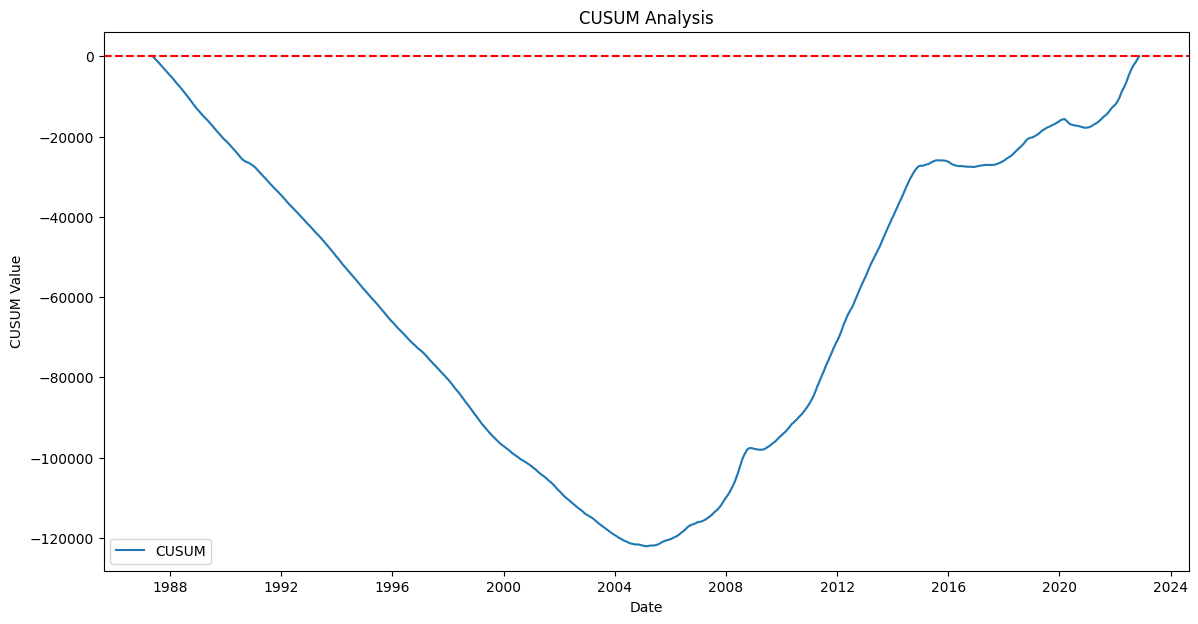

In [9]:
# CUSUM method
mean_price = df['Price'].mean()
cusum = np.cumsum(df['Price'] - mean_price)
plt.figure(figsize=(14, 7))
plt.plot(df.index, cusum, label='CUSUM')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Date')
plt.ylabel('CUSUM Value')
plt.title('CUSUM Analysis')
plt.legend()
plt.show()

## Change Analysis

2024-11-15 22:36:17,824 - INFO - Multiprocess sampling (2 chains in 2 jobs)
2024-11-15 22:36:17,824 - INFO - CompoundStep
2024-11-15 22:36:17,824 - INFO - >NUTS: [mean_prior]
2024-11-15 22:36:17,824 - INFO - >Metropolis: [change_point]


Output()

2024-11-15 22:36:30,750 - INFO - Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 13 seconds.
2024-11-15 22:36:30,839 - INFO - We recommend running at least 4 chains for robust computation of convergence diagnostics


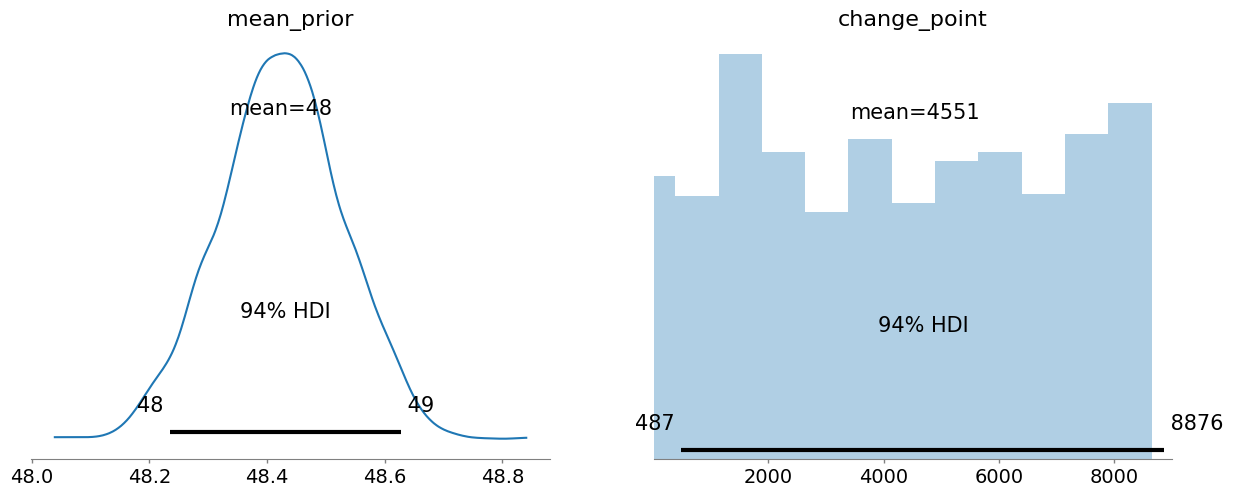

In [10]:

# Bayesian Change Point Detection using PyMC3
with pm.Model() as model:
    # Priors
    mean_prior = pm.Normal('mean_prior', mu=mean_price, sigma=10)
    change_point = pm.DiscreteUniform('change_point', lower=0, upper=len(df)-1)

    # Likelihood
    likelihood = pm.Normal('likelihood', mu=mean_prior, sigma=10, observed=df['Price'])

    # Inference
    trace = pm.sample(1000, tune=1000, cores=2)
    
# Plot results
pm.plot_posterior(trace)
plt.show()


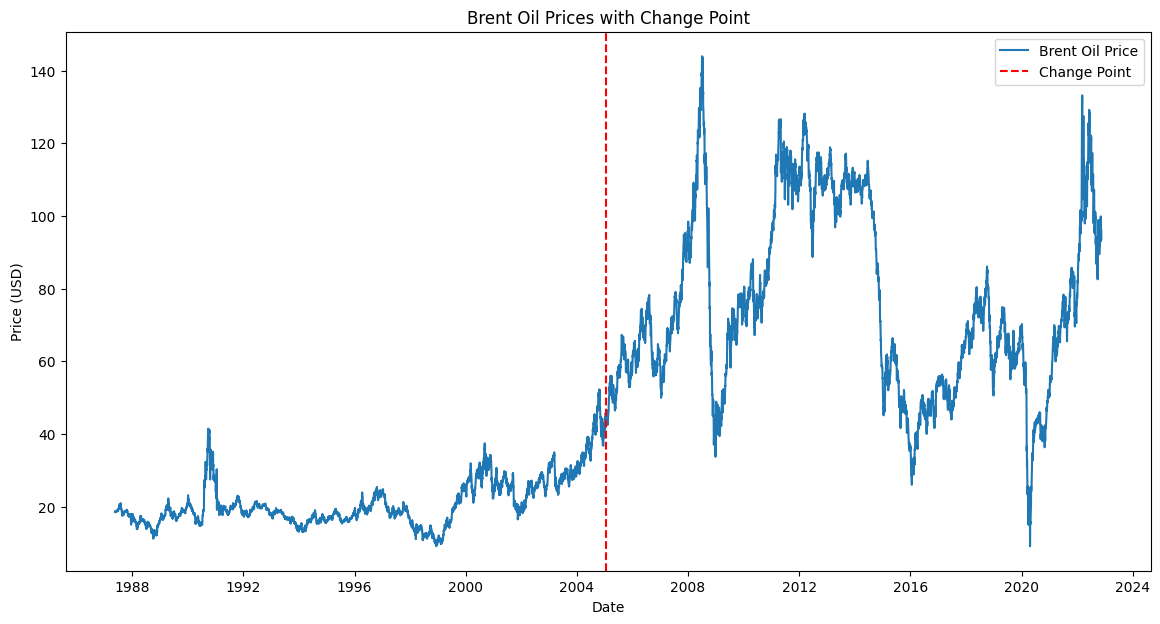

In [24]:
change_point_index = 4495

# Plot the data with the change point
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Price'], label='Brent Oil Price')
plt.axvline(x=df.index[change_point_index], color='red', linestyle='--', label='Change Point')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title('Brent Oil Prices with Change Point')
plt.legend()
plt.show()

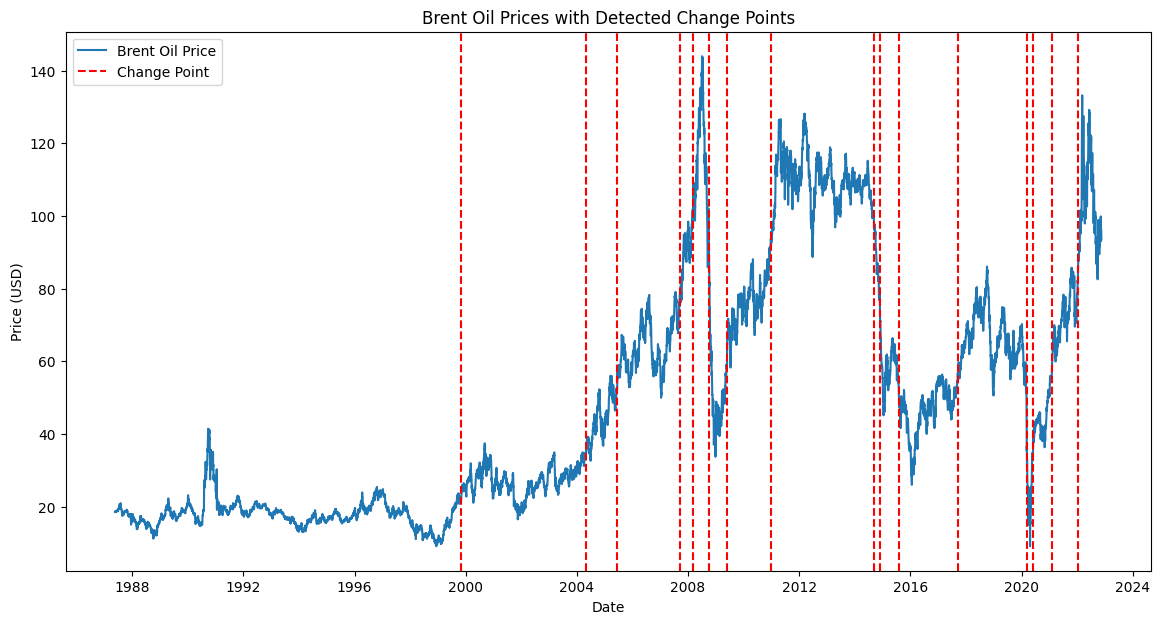

In [25]:
price_array = df['Price'].values
model = "rbf"
algo = rpt.Pelt(model=model).fit(price_array)
change_points = algo.predict(pen=20)

plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Price'], label='Brent Oil Price')
for cp in change_points[:-1]:
    plt.axvline(x=df.index[cp], color='red', linestyle='--', label='Change Point' if cp == change_points[0] else "")
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title('Brent Oil Prices with Detected Change Points')
plt.legend()
plt.show()